<a href="https://colab.research.google.com/github/stemgene/Prediction-of-Skilled-Nursing-Facility-SNF-for-recovery/blob/master/1.Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import datetime
import numpy as np
import pandas as pd
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder

Load dataset

In [0]:
df = pd.read_csv("snf.csv", header=0)

## 1. Data Inspection

To find the meaning of each feature, the relationship between features and result, approaches to modify features, and which features are important.

At first, let's take a look at data via Microsoft Excel. There are 35 features, 14 of them are object data type, others are int or float type.

Let's make some roughly ideas for how to deal with these features.

| feature name | description | approaches to modify it (if necessary) |
| -------      | -------     | --------------------                   |
| Patient_ID   | identify patient | deal with duplicate values        |
| ServiceDate  | year of create files | transfer to year from now |
| Gender |                  | replace by 1 and 0                   |
|State | NY and others    | replace by 1 and 0 |
| length of stay | days in hospital | normalization or hierarchization |
|Pat_Ethgrp  | ethnic  | hierarchization, handle missing data |
|Pat_Race  | race  | handle missing data, one hot code |
|RF10 | patient's status |  check correlatiionship |
|RF17(15 features)| patient's medical history |check correlatiionship|
|procName1| diagnose | extract information , replace by 3 features  |
|age_yrs | age string | handle outliers, transfer to integer type|
|Dx Code (3 features) |  unknown yet | handle miss data, numeric |
|provider | hospital?  | numeric |
|reg Fsc (2 features)| insurance?  | numeric |
|height | patient's height | combine to weight |
|weight | unit is oz | transform to BMI  | 
|previous_snf | snf history | keep this important feature |
INDEX_DISCH_DISP_NM | result | replace by 1 and 0 |

## 2. Data Pre-process

### Data Cleaning

#### 2.1 Patient_ID
There are some duplicate IDs which represent the same patient's different record on different time. The information of later one includes the former one roughly. Moreover, the column of "previous_snf" contains the patient's 'snf' history. Let's remove the former entry.

In [0]:
df = df.drop_duplicates("Patient_ID", keep='last')

#### 2.2 ServiceDate

Transfer year to how many years before now. (i.e.,2019-year)

In [0]:
df.loc[:, 'Service Date Year'] = df.loc[:, 'Service Date Year'].map(lambda x: 2019-x)

#### 2.3 Gender

Replace "M" by 0, "F" by 1, since the count numbers of 'F' is 1000 more than 'M'.

In [0]:
df.loc[:, 'Gender'] = df.loc[:, 'Gender'].map( {'F': 1, 'M': 0} ).astype(int)

#### 2.4 State

The number of 'NY' is dominated (4315/4366), let's map 'NY' by 1, others by 0

In [0]:
df.loc[:, 'State'] = df.loc[:, 'State'].str.find('NY').map({0:1, -1:0}).astype(int)

#### 2.5 length of stay	

This column's data type is integer, and there is not so many larger numbers. It's not necessary to do something. Let's keep it until normalization.

#### 2.6 Pat_EthGrp

In this column, "Not Hispanic or Latino" is dominating. Let's map it by '1'.

In [0]:
df.loc[:, 'Pat_EthGrp'] = df.loc[:, 'Pat_EthGrp'].map(\
{"Patient Refused":0, "Not Hispanic or Latino":1, "Hispanic or Latino":2}).astype(int)

#### 2.7 Pat_Race

Similar as last feature, "White or Caucasian" in this column is dominating, it should be mapped by '1'. Moreover, lat's combine "AMERICAN INDIAN OR ALASKA NATIVE", "Asian", "Patient Refused", and "Other" together because of low ratio, and replace by '0'.

In [0]:
df.loc[:, 'Pat_Race'] = df.loc[:, 'Pat_Race'].map(\
{"AMERICAN INDIAN OR ALASKA NATIVE":0, "Asian":0, "Other":0,\
"Patient Refused":0, "White or Caucasian":1, "Black or African American":2}).astype(int)

#### 2.8 INDEX_DISCH_DISP_NM

There are 12 NULL values. Since it's the final result to which we will compare, we can't guess whether or not the patients go to snf without a missing value. So I decide drop these rows of missing data.

Then, we only want 2 values, let's replace "To SNF (Skilled Nursing)"=1, others=0

In [0]:
df = df.dropna(subset=['INDEX_DISCH_DISP_NM'])
df.loc[:, 'INDEX_DISCH_DISP_NM'] = df.loc[:, 'INDEX_DISCH_DISP_NM'].str.find('To SNF (Skilled Nursing)').map({0:1, -1:0}).astype(int)

#### 2.9 ProcName1

Use regular expression to find key words in the column of "ProcName1", and input corresponding value to other three columns of "Side", "Knee or Hip", and "Anterior approach".

1. Before implement Re, let's look through the "ProcName1" column and find all values of key words.

    * Side
        * Unknown (0): Re does not find any pattern
        * Left (1): (L), LEFT, LEEFT, Left, left
        * Right (2): RIGHT, RIGH, Right
        * Both (3): BILATERAL, Bilateral, bilateral, LEFT AND RIGHT
    * Knee or Hip
        * Knee (0): KNEE, Knee, knee
        * Hip (1): HIP, Hip, hip
        * Unknown (2): Re does not find any pattern
    * Anterior approach
        * True (1): ANTERIOR, Anterior, anterior
        * False (0): Re does not find any pattern

2. Then compile Re patterns, find all key words.

3. Iterate each elements in "ProcName1" column, extract information and fill three integers to lists of "knee_hip", "anterior_app", and "side".

4. Insert three lists to the dataframe.

In [0]:
side = []
knee_hip = []
anterior_app = []
source = df.loc[:, "ProcName1"]

# patterns of side
pattern_SL = re.compile(r"left|lee|\(L\)", re.IGNORECASE) # 1
pattern_SR = re.compile(r"righ", re.IGNORECASE) # 2
pattern_SB = re.compile(r"bilater|LEFT AND RIGHT", re.IGNORECASE) # 3
# patterns of K or H
pattern_KHK = re.compile(r"knee", re.IGNORECASE) # 0
pattern_KHH = re.compile(r"hip", re.IGNORECASE) # 1
# patterns of Anterior Approach
pattern_AAT = re.compile(r"anterior", re.IGNORECASE) # 1

for S in source:
    # find side
    if pattern_SL.search(S):
        side.append(1)
    elif pattern_SR.search(S):
        side.append(2)
    elif pattern_SB.search(S):
        side.append(3)
    else:
        side.append(0)

    # find K or H
    if pattern_KHK.search(S):
        knee_hip.append(0)
    elif pattern_KHH.search(S):
        knee_hip.append(1)
    else:
        knee_hip.append(2)

    # find Anterior Approach
    if pattern_AAT.search(S):
        anterior_app.append(1)
    else:
        anterior_app.append(0)

# Insert to df
df.insert(25, "Side", side)
df.insert(26, "Knee or Hip", knee_hip)
df.insert(27, "Anterior Approach", anterior_app)

#### 2.10 age_yrs

This column's data type is string, because some outliers have to be writen "90+". Let's use some random numbers between 91-100 to replace them, and transfer this column' data type to integer. 

In [0]:
df.loc[:, "age_yrs"].replace("90+", str(random.randint(91,100)), inplace=True)
df.loc[:, "age_yrs"] = df.loc[:, "age_yrs"].astype(int)

#### 2.11 Dx Code

To pre-process these features, let's use the process shown as below.

1. There are 3 Dx Code's features which indicate patient's diagnoses given by doctors. Some patients have more than one diagnoses, so they need 3 columns to store. But most of them have one to two diagnoses. Therefore I decide to drop the third column.

2. There are too many sub-categories to analyze each one. We need to omit the sub-categories after the radix point and only keep the parent hierarchy.

3. ICD-9 and ICD-10 use different encoding criterions, we need to combine two kinds of codes to one if they represent one disease category.

4. After code combination, I found most of codes concentrate to 715 (M16, M17 in IDC-10) and 719 (M25 in ICD-10). So let's hierarchize them into three main stratum: 715, 719 and others.

5. Some patients have two diagnoses, we'd better to combine them to one new feature in order to learn better. 

|code 1 | code2 |combine|
|----|-----|-----|
|1  | 0 | 1 |
|2  | 0 | 2 |
|1  | 2 | 3 |
|2   | 1 | 3|
|others | others | 4 |
|others | 0 | 0|


In [0]:
# For column of "Dx Code 1"
# remove numbers after radix point.
code1 = df.loc[:, 'Dx Code 1'].str.split('.', expand=True)
code1[["code", "drop"]] = pd.DataFrame(code1)
# Use numeric number to replace original strings.
code1_name = code1.loc[:, "code"].unique()
code1_index = np.linspace(1, len(code1_name), len(code1_name), dtype=int)
code1_dic = dict(zip(code1_name, code1_index))
df.loc[:, 'Dx Code 1'] = code1.loc[:, 'code'].map(code1_dic).astype(int)

# M16, M17 of IDC-10 are corresponding to 715 of IDC-9; M25=719
#The rows of others are assigned to "Others", which is 9
maplist = np.linspace(9, 32, 24, dtype=int)
df.loc[:, 'Dx Code 1'].replace(maplist, 9, inplace=True)
df.loc[:, 'Dx Code 1'].replace({3:1, 4:1, 8:2}, inplace=True)


# Handle "Dx Code 2". Similar to "DX code 1", expect fill NULL value to '0' firstly.
df.loc[:, 'Dx Code 2'] = df.loc[:, 'Dx Code 2'].fillna('0')
code2 = df.loc[:, 'Dx Code 2'].str.split('.', expand=True)
code2[["code", "drop"]] = pd.DataFrame(code2)
code2_name = code2.loc[:, "code"].unique()   
code2_index = np.linspace(0, len(code2_name), len(code2_name), dtype=int)  # for nan value, index starts from 0
code2_dic = dict(zip(code2_name, code2_index))
df.loc[:, 'Dx Code 2'] = code2.loc[:, 'code'].map(code2_dic).astype(int)
maplist = np.linspace(7, 39, 33, dtype=int)
df.loc[:, 'Dx Code 2'].replace(maplist, 9, inplace=True)
df.loc[:, 'Dx Code 2'].replace({5:1, 6:1, 3:2}, inplace=True)

code_c = df.loc[:, ('Dx Code 1', 'Dx Code 2')]
# Combine two columns to a new one, use the mapping form above.
code_combine = []
for i, v in enumerate(code_c.loc[:,"Dx Code 1"]):
    if (v == 1) & (code_c.iloc[i,1] == 0):
        code_combine.append(1)
        continue
    elif (v == 2) & (code_c.iloc[i,1] == 0):
        code_combine.append(2)
        continue
    elif ((v == 1) & (code_c.iloc[i,1] == 2)) or ((v == 2) & (code_c.iloc[i,1] == 1)):
        code_combine.append(3)
        continue
    elif (v & code_c.iloc[i,1]) == 1:
        code_combine.append(4)
    elif (v & code_c.iloc[i,1]) == 0:
        code_combine.append(0)
    else:
        code_combine.append(0)

# Insert the new column to df
df.insert(32, "code combination", code_combine)

#### 2.12 Provider

Group and map to integers. The provider No.7,8, and 10-17 take quite low fraction (2.4%), they shoud be assigned to "Others"

In [0]:
# Create name and index mapping relationship
provider = df.loc[:, "Provider"].unique()
index = np.linspace(1, len(provider), len(provider), dtype=int)
provider_dic = dict(zip(provider, index))

df.loc[:, 'Provider'] = df.loc[:, 'Provider'].map(provider_dic).astype(int)

# The rows of provider 7,8, and 10-17 take quite low fraction (2.4%), they shoud be assigned to "Others"
df.loc[:, 'Provider'].replace([7,8,10,11,12,13,14,15,16,17], 0, inplace=True)

#### 2.13 Reg Fsc 1 & 2

These columns are important. Since snf care is so expensive that whether the patient could afford the payment should be considered as a significant factor. For example, there are two patient without any insurance and they had to go back home.

Furthermore, we can't assign smaller percentage items to "others", just the reverse, fewer people will buy more expensive insurance, but it will  cover more. Another words, rich people tends to snf care. On the other hand, some insurance products rarely catch enough attention of patients due to lack of coverage. In my opioning, the number of customers and price of health insurance obey Guassian distribution, i.e., few people purchase costly insurance or cheapest but useless insurance. These inference will affect the result of prediction.

Unfortunately, we can't get more information of these insurance, let's just mapping them into integer. NULL value is a status of insurance and won't be omitted.

In [0]:
# Create insurance name and index mapping relationship
insurance1 = df.loc[:, "Reg Fsc 1"].unique()
index = np.linspace(1, len(insurance1), len(insurance1), dtype=int)
insurance1_dic = dict(zip(insurance1, index)) # {NaN:24}

df.loc[:, 'Reg Fsc 1'] = df.loc[:, 'Reg Fsc 1'].map(insurance1_dic).astype(int)

# Create insurance name and index mapping relationship
insurance2 = df.loc[:, "Reg Fsc 2"].unique()
index = np.linspace(1, len(insurance2), len(insurance2), dtype=int)
insurance2_dic = dict(zip(insurance2, index)) # {NaN:12}

df.loc[:, 'Reg Fsc 2'] = df.loc[:, 'Reg Fsc 2'].map(insurance2_dic).astype(int)

#### 2.14 Height

I tried to transform this column to integer data type, and represent by inches instead of feet+inches. Moreover, I wanted to calculate the BMI index to replace "Height" and "Weight".

However, I spent many hours to parse the strings by Re, but there are several rows can't be applied. Finally, due to the deadline, I decide to drop this column and use "weight" to discribe patients' physical characters.

I will show the pseudocode below, although it can't work.

We know that obeseness makes arthrosis of knee and hip worse. There is an attribute called BMI. Body mass index is a value derived from the mass and height of a person. The BMI is defined as the body mass divided by the square of the body height.

Let's combine height and weight to BMI and assign them to several hierarchies.

I found there are abnormal values, e.g., "7' .008"", "5\' 4.016",", 'nan', '5\' 7"[Stimu..[", '[167.6['.

In [0]:
# height = df.loc[:, "height"].astype(str)  # there are 4 float type in "height"

## Parse string and float type
# hh = []
# pattern_h1 = re.compile(r"\d\'.\d\.", re.IGNORECASE) # '5\' 3.504"'
# pattern_h2 = re.compile(r"\d\'.\.", re.IGNORECASE) # '6\' .008"'
# pattern_h3 = re.compile(r"\[", re.IGNORECASE)  # [173 [
# pattern_h4 = re.compile(r"N", re.IGNORECASE)  # nan
# for i, S in enumerate(height):
#     if pattern_h1.search(S):
#         h1 = re.sub(r'\.\d+', r'', S) # '5\' 3"'
#         hh.append(h1)
#     elif pattern_h2.search(S):
#         h2 = re.sub(r'\.\d+', r'0', S) # '6\' 0"'
#         hh.append(h2)
#     elif pattern_h3.search(S):
#         h3 = height[i-1]
#         hh.append(h3)
#     elif pattern_h4.search(S):
#         h4 = height[i-1]
#         hh.append(h4)
#     else:
#         hh.append(S)

# # transform to inches
# H = "5' 3504\""
# H_feet = H.split("'")[0]
# H_inch = H.split("'")[1].split("\"")[0]

# H_inches = int(H_feet) * 12 + int(H_inch)
# H_inches

#### 2.15 Weight

Supposely heavier in weight, more presure suffered by arthrosis.

At first, I was considering to divide this column to several stratum, e.g., skim, medium, and heavy. But there seems no difference of rate of going to snf. Therefore I decide to keep the original data, and take normalization instead.

In [0]:
df.loc[:, "CategoricalWeight"] = pd.qcut(df.loc[:, "weight"], 3)

In [0]:
print(df[["CategoricalWeight", "INDEX_DISCH_DISP_NM"]].groupby(["CategoricalWeight"], as_index=False).mean())

    CategoricalWeight  INDEX_DISCH_DISP_NM
0  (1295.999, 2704.0]             0.316961
1    (2704.0, 3296.0]             0.265949
2    (3296.0, 5600.0]             0.210568


## 3 Feature Selection

#### 3.1 Drop useless features

In [0]:
# Let's keep almost all features except those have been replaced by new ones.
drop_elements = ['ProcName1', 'Dx Code 1', 'Dx Code 2', 'Dx Code 3', 'height','CategoricalWeight']
df_cleaned = df.drop(drop_elements, axis = 1)   

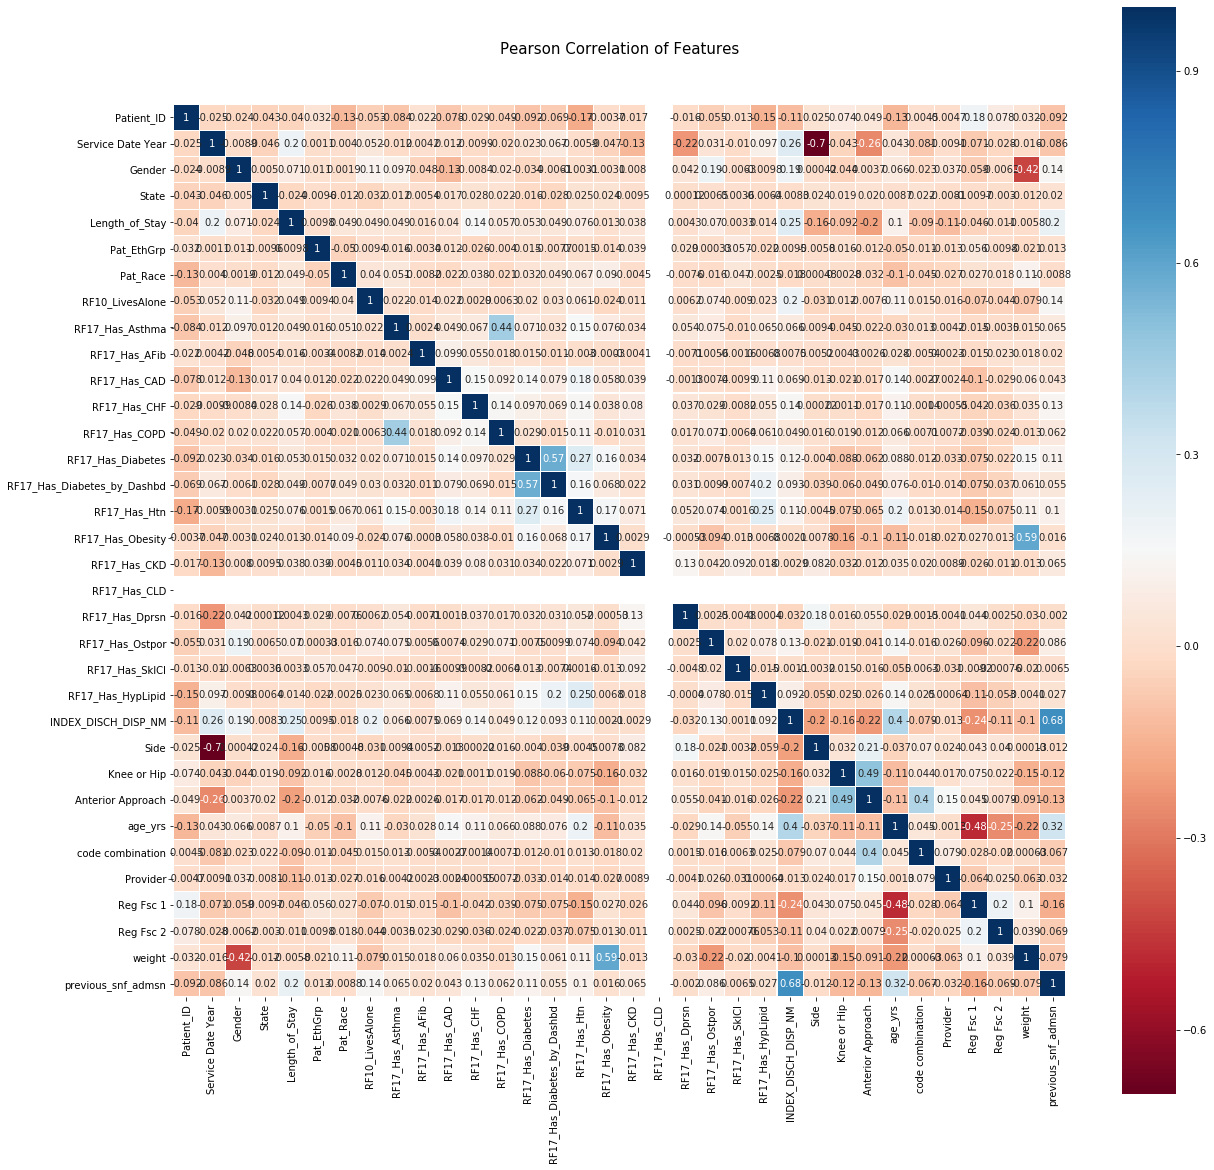

In [0]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_cleaned.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


We can find there are some feature pairs with relative high positive and negtive correlation, 
* Positive Correlation
    * "INDEX_DISCH_DISP_NM" and "previous_snf_admsn", of course they do, if a patient has been snf once, he may go the second time.
    * "weight" and "Obesity", it makes sense, but the correlation value isn't so greate.
    * "Diabetes" and "diabetes by dashbd".
* Negative Correlation
    * "side" and "Service Date Year", I guess it may be not a long time to record which side of arthroplasty, for those patients who don't have side records because when they took this operation, doctors didn't record it at all.
    * "age" and "insurance", it's reasonable, since the health insurance products always be dedigned for different age groups.
    * "weight" and "gender", male patients are heavier than females.

Although we can find some pairs of correlation, the relationship is not strong enough to alternate each other. So we don't want to drop any of them. 

#### 3.2 PCA dimension deduction

Let's try to apply PCA to reduce features of df. I set the parameter of "n_components" to "mle" which means choose dimension automaticly. It returned a matrix of 33 dimensions. I'll use this data as comparation.

In [0]:
from sklearn.decomposition import PCA 
pca=PCA(n_components='mle')
newData=pca.fit_transform(df_cleaned)
newData.shape

(3872, 33)

## 4. Normalization

Let's apply normalization on "weight" and "Length_of_stay". I use the method of n/N.max in order to keep the original ratio among elements.

In [0]:
weight_max = df.loc[:,'weight'].max()
df_cleaned.loc[:, 'weight'] = df.loc[:, 'weight'].map(lambda x: x/weight_max)

In [0]:
stay_max = df.loc[:, "Length_of_Stay"].max()
df_cleaned.loc[:, 'Length_of_Stay'] = df.loc[:, 'Length_of_Stay'].map(lambda x: x/stay_max)